In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

In [14]:
df = pd.read_csv("../DATA/4-hours Pepperstone/4-hours_EURUSD.csv")

In [15]:
def dc_event(Pt, Pext, threshold):
    """
    Compute if we have a POTENTIAL DC event
    """
    var = (Pt - Pext) / Pext
    
    if threshold <= var:
        dc = 1
    elif var <= -threshold:
        dc = -1
    else:
        dc = 0
        
    return dc


def calculate_dc(df, threshold):
    """
    Compute the start and the end of a DC event
    """
    
    # Initialize lists to store DC and OS events
    dc_events_up = []
    dc_events_down = []
    dc_events = []
    os_events = []

    # Initialize the first DC event
    last_dc_price = df["close"][0]
    last_dc_direction = 0  # +1 for up, -1 for down
    
    # Initialize the current Min & Max for the OS events
    min_price = last_dc_price
    max_price = last_dc_price
    idx_min = 0
    idx_max = 0

    
    # Iterate over the price list
    for i, current_price in enumerate(df["close"]):
        
        # Update min & max prices
        try:
            max_price = df["high"].iloc[dc_events[-1][-1]:i].max()
            min_price = df["low"].iloc[dc_events[-1][-1]:i].min()
            idx_min = df["high"].iloc[dc_events[-1][-1]:i].idxmin()
            idx_max = df["low"].iloc[dc_events[-1][-1]:i].idxmax()
        except Exception as e:
            pass
            #print(e, dc_events, i)
            #print("We are computing the first DC")
        
        # Calculate the price change in percentage
        dc_price_min = dc_event(current_price, min_price, threshold)
        dc_price_max = dc_event(current_price, max_price, threshold)
        
        
        # Add the DC event with the right index IF we are in the opposite way
        # Because if we are in the same way, we just increase the OS event size
        if (last_dc_direction!=1) & (dc_price_min==1):
            dc_events_up.append([idx_min, i])
            dc_events.append([idx_min, i])
            last_dc_direction = 1
            
        elif (last_dc_direction!=-1) & (dc_price_max==-1):
            dc_events_down.append([idx_max, i])
            dc_events.append([idx_max, i])
            last_dc_direction = -1
        
    return dc_events_up, dc_events_down, dc_events


def calculate_trend(dc_events_down, dc_events_up, df):
    """
    Compute the DC + OS period (trend) using the DC event lists
    """
    
    # Initialize the variables
    trend_events_up = []
    trend_events_down = []
    
    # Verify which event occured first (upward or downward movement)
    
    # If the first event is a downward event
    if dc_events_down[0][0]==0:
        
        # Iterate on the index 
        for i in range(len(dc_events_down)):
            
            # If it is the value before the last one we break the loop
            if i==len(dc_events_down)-1:
                break
                
            # Calculate the start and end for each trend
            trend_events_up.append([dc_events_up[i][1], dc_events_down[i+1][1]])
            trend_events_down.append([dc_events_down[i][1], dc_events_up[i][1]])
    
    # If the first event is a upward event
    elif dc_events_up[0][0]==0:
        
        # Iterate on the index
        for i in range(len(dc_events_up)):
            
            # If it is the value before the last one we break the loop
            if i==len(dc_events_up)-1:
                break
                
            # Calculate the start and end for each trend
            trend_events_up.append([dc_events_down[i][1], dc_events_up[i+1][1]])
            trend_events_down.append([dc_events_up[i][1], dc_events_down[i][1]])

    # Verify the last indexed value for the down ward and the upward trends
    last_up = trend_events_up[-1][1]
    last_down = trend_events_down[-1][1]

    # Find which trend occured last to make it go until now
    if last_down < last_up:
        trend_events_up[-1][1] = len(df)-1
    else:
        trend_events_down[-1][1] = len(df)-1
        
    return trend_events_down, trend_events_up

def get_dc_price(dc_events, df):
    dc_events_prices = []
    for event in dc_events:
        prices = [df["close"].iloc[event[0]], df["close"].iloc[event[1]]]
        dc_events_prices.append(prices)
    return dc_events_prices

In [17]:
df.iloc[1_000:2_000]

,time,open,high,low,close,tick_volume,low_time,high_time
1000,2015-08-18 04:00:00,1.10756,1.10815,1.10713,1.10765,11432,2015-08-18 06:00:00,2015-08-18 05:36:00
1001,2015-08-18 08:00:00,1.10764,1.10903,1.10511,1.10891,21483,2015-08-18 08:24:00,2015-08-18 11:36:00
1002,2015-08-18 12:00:00,1.10890,1.10935,1.10551,1.10600,29080,2015-08-18 14:48:00,2015-08-18 12:00:00
1003,2015-08-18 16:00:00,1.10599,1.10654,1.10171,1.10263,34934,2015-08-18 19:36:00,2015-08-18 16:24:00
1004,2015-08-18 20:00:00,1.10261,1.10365,1.10175,1.10315,14137,2015-08-18 22:48:00,2015-08-18 23:12:00
...,...,...,...,...,...,...,...,...
1995,2016-04-01 16:00:00,1.14188,1.14377,1.13344,1.13842,56387,2016-04-01 18:00:00,2016-04-01 16:00:00
1996,2016-04-01 20:00:00,1.13841,1.14032,1.13806,1.13900,26598,2016-04-01 20:00:00,2016-04-01 20:48:00
1997,2016-04-02 00:00:00,1.13898,1.13989,1.13849,1.13897,2678,2016-04-02 00:00:00,2016-04-02 00:00:00
1998,2016-04-04 00:00:00,1.13994,1.13996,1.13875,1.13943,4605,2016-04-04 02:00:00,2016-04-04 00:48:00


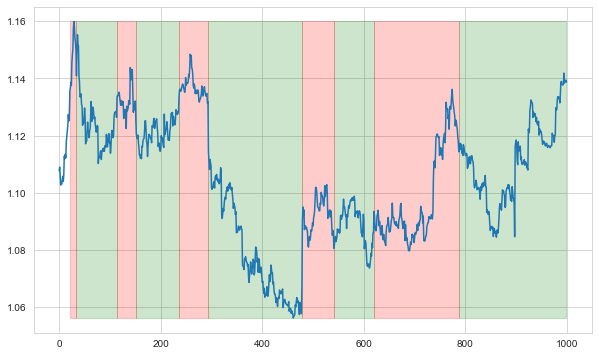

In [18]:
# Take the data
dfc = df.iloc[1_000:2_000].reset_index()

# Extract DC and Trend events
dc_events_up, dc_events_down, dc_events = calculate_dc(dfc, threshold=0.02)
trend_events_down, trend_events_up = calculate_trend(dc_events_down, dc_events_up, dfc)


min_price = dfc['close'].min()
max_price = dfc['close'].max()

plt.figure(figsize=(10, 6))
plt.plot(dfc['close'].iloc[0:,], label='Price')

# Add DC and OS events to the plot
for start, end in trend_events_up:
    plt.fill_between(dfc.index[start:end+1], min_price, max_price, alpha=0.2, color='green', label='DC Event')
    
for start, end in trend_events_down:
    plt.fill_between(dfc.index[start:end+1], min_price, max_price, alpha=0.2, color='red', label='DC Event')

plt.show()

In [24]:
def DC_market_regime(df, threshold):
    """
    Determines the market regime based on Directional Change (DC) and trend events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        A DataFrame containing financial data. The DataFrame should contain a 'close' column 
        with the closing prices, and 'high' and 'low' columns for high and low prices.
    
    threshold : float
        The percentage threshold for DC events.
    
    Returns:
    --------
    df_copy : pandas.DataFrame
        A new DataFrame containing the original data and a new column "market_regime", 
        which indicates the market regime at each timestamp. A value of 1 indicates 
        an upward trend, and a value of 0 indicates a downward trend.
        
    """
    df_copy = df.copy()
    
    # Extract DC and Trend events
    dc_events_up, dc_events_down, dc_events = calculate_dc(df_copy, threshold=threshold)
    trend_events_down, trend_events_up = calculate_trend(dc_events_down, dc_events_up, df_copy)
    
    df_copy["market_regime"] = np.nan
    for event_up in trend_events_up:
        df_copy.loc[event_up[1], "market_regime"] = 0

    for event_down in trend_events_down:
        df_copy.loc[event_down[1], "market_regime"] = 1

    df_copy["market_regime"] = df_copy["market_regime"].fillna(method="ffill")
    
    return df_copy

In [25]:
dft = DC_market_regime(df.iloc[1000:2000,:].reset_index(),0.02)

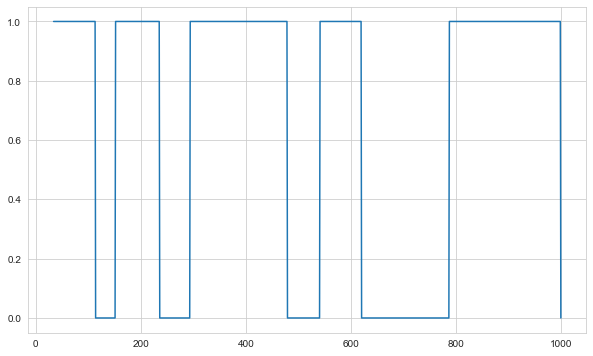

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(dft['market_regime'].iloc[:,], label='Price')
plt.show()